This document is an exercise on the estimation of the Heat Loss Coefficient of a house, along with other characteristics, using a relatively long dataset and linear regression. It is made of the following three parts:
1. Problem statement
2. Example of resolution
    1. Linear regression
    2. Energy signature
3. Exercise

## 1. Problem statement

### Data

A single-family house has been monitored for 3 years between 2012 and 2015. The target of the exercise is to fit a linear regression model on this data, in order to estimate the performance of the house.

<img src='images/gainsborough.png' width=300 />

First, we load the data into a dataframe named `data_`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing data into a dataframe with the pandas library
data_ = pd.read_csv('data/lin_reg_data.csv', encoding="ISO-8859-1", sep=';', decimal=',')
data_.set_index(pd.to_datetime(data_['Time'], dayfirst=True), inplace=True)

# This line shows the first few lines of the dataset
data_.head()

,Time,T_in,T_ext,T_adj,T_sup,CO2,E_sol [J/m2],E_hea [J],E_elec [J]
Time,,,,,,,,,
2014-10-01,01/10/2014,24.14,16.36,22.46,24.43,806.40,2.130851e+07,1.146730e+06,54472552.46
2014-10-04,04/10/2014,22.57,11.45,21.42,22.43,957.60,1.458457e+07,4.457914e+07,76553697.54
2014-10-07,07/10/2014,22.16,10.21,21.19,22.27,1041.92,1.462878e+07,5.916412e+07,63980905.46
2014-10-10,10/10/2014,22.42,11.22,21.28,22.83,881.17,2.571385e+07,6.539946e+07,54232695.66
2014-10-13,13/10/2014,22.31,12.00,21.34,22.62,869.94,8.682955e+06,5.239124e+07,57644390.10


The data file contains one year of measurements that have been averaged over periods of three days. The following block plots all available data.

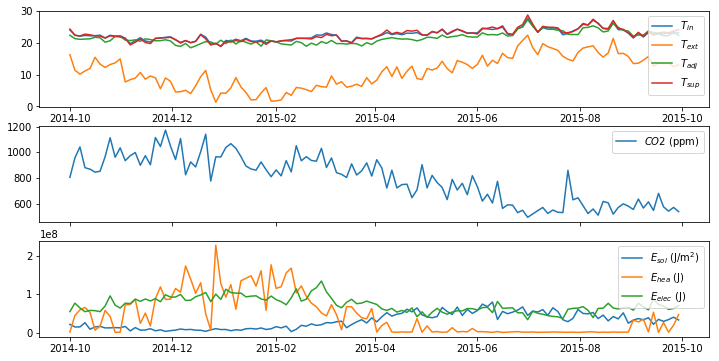

In [3]:
plt.figure(figsize=(12,6))

ax1 = plt.subplot(311)
plt.plot(data_['T_in'], label='$T_{in}$')
plt.plot(data_['T_ext'], label='$T_{ext}$')
plt.plot(data_['T_adj'], label='$T_{adj}$')
plt.plot(data_['T_sup'], label='$T_{sup}$')
plt.legend()
#plt.setp(ax1.get_xticklabels(), fontsize=6)

# share x only
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(data_['CO2'], label='$CO2$ (ppm)')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.legend()

# share x and y
ax3 = plt.subplot(313, sharex=ax1)
plt.plot(data_['E_sol [J/m2]'], label='$E_{sol}$ (J/m$^2$)')
plt.plot(data_['E_hea [J]'], label='$E_{hea}$ (J)')
plt.plot(data_['E_elec [J]'], label='$E_{elec}$ (J)')
plt.legend()

plt.show()

### Model

We will describe heat transfer in the house with the following model.

<img src='images/problem_statement.png' width=500 />

The methodology is based on a very simplified steady-state heat balance over the house, represented by a single temperature zone.

$$ \Phi_h + gA \: \Phi_{sol} = H \: (T_{in} - T_{ext}) + H_{part} \; (T_i-T_{adj}) - q_{sup} \, c_p \: (T_{in}-T_{sup}) + c $$

Where the following variables originate from the data:

* $\Phi_h = E_h / \Delta_t$ (W) is the indoor heating power (W), where $E_h$ (J) is the heating energy spent during each data period. $\Delta t$ (s) is the time step size.
* $\Phi_{sol} = \: E_{sol} / \Delta_t$ (W/m2) is the solar irradiance measured outside of the building. $gA$ (m2) is an unknown solar aperture coefficient.
* $T_{in}$ is the indoor temperature of house 1, averaged between the lounge and the bedroom.
* $T_{ext}$ is the outdoor temperature.
* $T_{adj}$ is the average temperature of the adjacent house.
* $T_{sup}$ is the MVHR supply temperature.

And the following variables are coefficients that will be estimated by linear regression:
* $H$ is the heat loss coefficient of the house.
* $gA$ is the solar aperture coefficient.
* $H_{part}$ is the transmission coefficient of the partition wall with the neighboring house.
* $q_{sup}$ and $c_p$ are respectively the flow rate and specific heat of the mechanical ventilation with heat recovery.
* $c$ is a constant

In [5]:
# Translating energies (J) into powers (W)
Delta_t = (data_.index[1] - data_.index[0]).total_seconds()
data_['Phi_h'] = data_['E_hea [J]'] / Delta_t
data_['Phi_sol'] = data_['E_sol [J/m2]'] / Delta_t
data_['Phi_elec'] = data_['E_elec [J]'] / Delta_t

## Resolution

### Linear regression

The goal of linear regression analysis is to determine a linear relationship between a dependent variable $y$ and one or more independent variables $x$.

$$ y = a_1 x_1 + a_2 x_2 + b $$

The energy balance can be formulated as this type of relationship.

<img src='images/linear_regression_1.png' width=200 />

Let us first assume that $gA$ is known, and that there is only one term of heat transmission. The output variable $y$ is the sum of heat sources $\Phi_h+gA \, \Phi_{sol}$. There is only one input variable $x$: the indoor-outdoor temperature difference, called $\Delta \theta_{ie}$ in the graph above.

$$\underbrace{\Phi_h+gA \, \Phi_{sol}}_y = H \underbrace{\left(T_i - T_e \right)}_x + b$$

The `statsmodels` python package includes simple methods for regression.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     684.1
Date:                Thu, 12 Sep 2019   Prob (F-statistic):           1.25e-51
Time:                        16:18:34   Log-Likelihood:                -827.06
No. Observations:                 122   AIC:                             1656.
Df Residuals:                     121   BIC:                             1659.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            41.8408      1.600     26.156      0.0

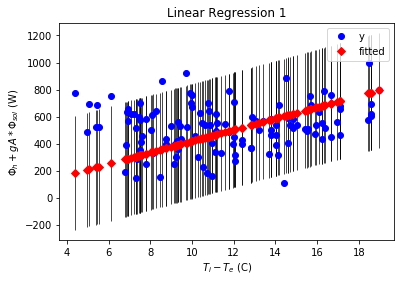

In [7]:
gA = 3.

import statsmodels.api as sm

# Definition of the output data y1 and the input data x1
y1 = data_['Phi_h'] + gA * data_['Phi_sol']
x1 = data_['T_in'] - data_['T_ext']
#x1 = np.column_stack((data_['T_in'] - data_['T_ext'], np.ones(len(data_))))

# Fitting the linear regressor and showing results
res_LR1 = sm.OLS(y1, x1).fit()
print(res_LR1.summary())

# I added a plot of the results
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_LR1, 0, ax=ax)
ax.set_ylabel('$\Phi_h + gA * \Phi_{sol}$ (W)')
ax.set_xlabel('$T_i - T_e$ (C)')
ax.set_title("Linear Regression 1")
plt.show()

How can these results be interpreted?

### Second linear regression

In the second approach, gA is estimated along with H.

<img src='images/linear_regression_2.png' width=200 />

Linear regression with two or more input variables is possible, and done the same way as with one.

$$\underbrace{\Phi_h}_y = H \underbrace{\left(T_i - T_e \right)}_{x_1} - gA \, \underbrace{\Phi_{sol}}_{x_2} + b$$

                            OLS Regression Results                            
Dep. Variable:                  Phi_h   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     288.4
Date:                Thu, 12 Sep 2019   Prob (F-statistic):           1.45e-46
Time:                        16:18:34   Log-Likelihood:                -746.65
No. Observations:                 122   AIC:                             1497.
Df Residuals:                     120   BIC:                             1503.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            26.9884      1.167     23.122      0.0

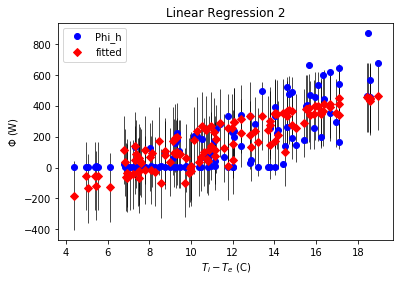

In [9]:
# Definition of the output data y2 and the two inputs in x2
y2 = data_['Phi_h']
x2 = np.column_stack((data_['T_in'] - data_['T_ext'], data_['Phi_sol']))
# Model fitting
res_LR2 = sm.OLS(y2, x2).fit()
print(res_LR2.summary())

fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_LR2, 0, ax=ax)
ax.set_ylabel('$\Phi$ (W)')
ax.set_xlabel('$T_i - T_e$ (C)')
ax.set_title("Linear Regression 2")
plt.show()

### Energy signature method

In the energy signature method, the solar aperture is supposed known. We estimate $H$ along with the base temperature $T_b$. The first thing to do is define a function that outputs heating power as a function of outdoor temperature, HLC and $T_b$.

<img src='images/energy_signature.png' width=250 />

This is more complicated than linear regression since there is no linear relationship between $\Phi_h$ and the base temperature $T_b$. Here is a way to solve for $H$ and $T_b$ using an optimisation algorithm.

In [11]:
def signature(te, H, tb):
    """
    This function predicts the heating power P by the energy signature method
    :param te: Outdoor temperature (C)
    :param H: Heat loss coefficient (W/K)
    :param tb: Base temperature for heating (C)
    :return: Heating power (W)
    """
    P = np.zeros_like(te)

    mask1 = te < tb
    P[mask1] += H * (tb-te[mask1])

    return P

This function is then fitted to find the optimal values for HLC and $T_b$. In the output data array, the total thermal power includes solar irradiance and the known aperture gA. Built-in methods of the `scipy` library are quite simple to use:

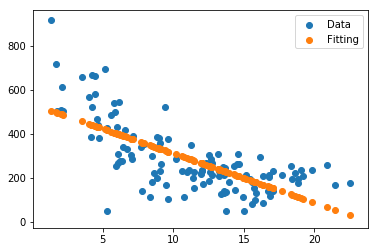

Energy signature method: H mean = 22.4 W/K ; std = 2.1 W/K
Tb mean = 23.9 C ; std = 1.3 C


In [12]:
gA = 1.

# Output data: 
y_ES = data_['Phi_h'] + gA * data_['Phi_sol']

from scipy.optimize import curve_fit
popt, pcov = curve_fit(signature,
                       xdata = data_['T_ext'],
                       ydata = y_ES,
                       p0 = [250, 10])

plt.figure()
plt.scatter(data_['T_ext'], y_ES, label='Data')
plt.scatter(data_['T_ext'], signature(data_['T_ext'], popt[0], popt[1]), label='Fitting')
plt.legend()
plt.show()

print('Energy signature method: H mean = %.1f W/K ; std = %.1f W/K' % (popt[0], pcov[0,0]**0.5))
print('Tb mean = %.1f C ; std = %.1f C' % (popt[1], pcov[1,1]**0.5))

## Exercise

Use the examples above to solve the following problems:

* Is the energy balance of the house impacted by the temperature of the adjacent house $T_{adj}$ and the air supply temperature?
* Apply the energy signature method with an unknown solar aperture coefficient.
* Does the electricity consumption $E_{elec}$ have an impact on the heat balance?